In [1]:
import numpy as np
from numba import jit
from tqdm import tqdm
import math
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
import dask
dask.config.set(scheduler='processes')
import dask.array as da
import sparse
import torch
import jpcm
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot as plt

In [2]:
C = 299792458.0 * np.power(10.0,-6)
LX = 77.4
Radius = 784.0/2 + (0.5*LX)
R = Radius
Z = 1000
UZ = Z/2
LZ = Z
nArray=24
theta=2*np.pi/nArray

matrix_bins = np.array([512,512,1024])
matrix_binT = (512,512,1024)
matrix_halfbins = matrix_bins/2
matrix_center = np.array([0,0,UZ])
matrix_halflength = np.array([R,R,UZ])
matrix_chunks = np.array([128,128,128])
matrix_vis_limit = 5

ex = np.sqrt(7.961**2)# + 20.56**2)
ey = np.sqrt(4.237**2)# + 28.84**2)
ez = np.sqrt(12.282**2)# + 15.69**2) #mm
et = 0.068 #ns
eth = ey/R

FWHM = 2*np.sqrt(2*np.log(2))
class Options:
    datadir = ""
    TotalEvents = 50 #squared!
    plotDIR = ""
#

In [3]:
@jit
def xyz(r,th,z):
    return [r*np.cos(th),r*np.sin(th),z]   
@jit
def tf(ps,th,phi):
    xp = ps[0]
    zp = ps[1]
    secth = 1.0/np.cos(th)
    secphi = 1.0/np.cos(phi)
    tanth = np.tan(th)
    sec2 = np.power(secth,2)
    tan2 = np.power(tanth,2)
    xdet = np.sqrt(R*R*(sec2) - xp*xp*tan2)/sec2
    xb = -xp/sec2
    x1 = xb+xdet
    x2 = xb-xdet
    # print("TH",th[80:120])
    # print("X1",x1[80:120])
    # print("X2",x2[80:120])
    th1 = np.arctan2(x1*tanth,x1+xp)#np.arcsin((x1*tanth)/R)
    th2 = np.pi + np.arctan2(-x2*tanth,-x2-xp)#np.arcsin((-x2*tanth)/R)
    # print("th1",th1[80:120])
    # print("th2",th2[80:120])
    a1 = np.sqrt(R**2 + xp**2 - 2*R*xp*np.cos(th1))
    a2 = np.sqrt(R**2 + xp**2 - 2*R*xp*np.cos(2*np.pi - th2))
    # print("a1",(a1)[80:120])
    # print("a2",(a2)[80:120])
    z1 = a1*np.tan(phi) + zp + UZ
    z2 = -a2*np.tan(phi) + zp + UZ
    l1 = np.sqrt(a1**2 + (z1-zp-UZ)**2)
    l2 = np.sqrt(a2**2 + (z2-zp-UZ)**2)
    indx = (z2 >= 0) & (z2 < LZ) & (z1 >= 0) & (z1 <= LZ)
    sens = np.sum(indx)/len(z1)
    # print("Sensitivity: ",sens)
    # print(l1[indx])
    # print(l2[indx])
    # print(a1[indx])
    # print(a2[indx])
    # m,n,o = xyz(np.repeat(R,np.sum(indx)),th1[indx],z1[indx])
    # print(np.sqrt((m-200)**2+n**2+(o-UZ)**2))
    return [l1[indx],th1[indx],z1[indx],l2[indx],th2[indx],z2[indx]],sens
@jit
def noisify(inp,scale=0):
    [l1,th1,z1,l2,th2,z2],sens = inp
    L = len(th1)
    return [np.repeat(R,L)+scale*ex*np.random.standard_normal(size=L),\
            th1+scale*eth*np.random.standard_normal(size=L),\
            z1+scale*ez*np.random.standard_normal(size=L),\
            l1/C + scale*et*np.random.standard_normal(size=L),\
            np.repeat(R,L)+scale*ex*np.random.standard_normal(size=L),\
            th2+scale*eth*np.random.standard_normal(size=L),\
            z2+scale*ez*np.random.standard_normal(size=L),\
            l2/C + scale*et*np.random.standard_normal(size=L)],sens
def toXYZ(inp):
    a,b,c,d,e,f,g,h = inp
    m,n,o = xyz(a,b,c)
    p,q,s = xyz(e,f,g)
    # print(np.sqrt((m-20)**2+n**2+(o-UZ)**2))
    # print(np.sqrt((p-20)**2+q**2+(s-UZ)**2))
    # print(m)
    # print(p)
    return np.asarray([m,n,o,d,p,q,s,h])
def xyzt(point,N,scale):
    th, ph = np.mgrid[0:2*np.pi:1j*(N+1), -np.pi/2:np.pi/2:1j*(N+1)]
    th0 = th.flatten()
    ph0 = ph.flatten()
    # th0 = np.linspace(0,2*np.pi,N)
    # ph0 = np.repeat(0.0,len(th0))
    out,sens = noisify(tf(point,th0,ph0),scale)
    return toXYZ(out),sens 

In [4]:
@jit
def ArrayToGlobalCoordinates(x,y,z,A):
    angle = A*theta
    cosine = math.cos(angle)
    sine = math.sin(angle)
    x_global = (Radius+x)*cosine - y*sine
    y_global = (Radius+x)*sine + y*cosine
    return np.array([x_global,y_global,z])
def plot(source,N,scale):
    p,sens = xyzt(source,N,scale)
    det = np.array([
        np.array([
            ArrayToGlobalCoordinates(0, 0, 0, A),
            ArrayToGlobalCoordinates(0, 0, LZ, A),
        ]).T
        for A in range(nArray)
    ])
    Lpoint = np.array([[0, 0, -UZ],[0, 0, LZ+UZ]]).T

    dt = (p[3]-p[7])
    dx = 0.5*C*dt #mm
    center = np.array([(p[0,:]+p[4,:])/2, (p[1,:]+p[5,:])/2, (p[2,:]+p[6,:])/2])
    line = -np.array(((p[0,:]-p[4,:]), (p[1,:]-p[5,:]), (p[2,:]-p[6,:])))
    shift = dx*line/(np.linalg.norm(line,axis=0))
    point = center+shift
    # D1 = (np.reshape(np.repeat([source[0],0,source[1]+UZ],center.shape[1]),center.shape)-center)
    # D2 = (np.reshape(np.repeat([source[0],0,source[1]+UZ],center.shape[1]),center.shape)-p[0:3])
    # DP = np.sum(D1*D2,axis=0)/(np.linalg.norm(D1,axis=0)*np.linalg.norm(D2,axis=0))
    # print(DP[0:400])
    print(dt)
    print(shift.T)
    print((np.reshape(np.repeat(np.array([source[0],0,source[1]+UZ]),center.shape[1]),center.shape) - center).T)
    stds = np.std(point,axis=1)
    print("ERROR: ",stds)
    
    np.savetxt(Options.datadir+"reco_pointdata.txt",point)

    xyz = point

    # with open(Options.render_pkl, 'wb') as f:  # Python 3: open(..., 'wb')
    #     pickle.dump(xyz, f)

    xy = np.vstack([xyz[0],xyz[2],xyz[1]])
    z = gaussian_kde(xy)(xy)
    #ax1.scatter(b, data["CTR"], c=z, s=16, cmap = "nipy_spectral")

    cmap = jpcm.get("fuyu")
    # fig = plt.figure(figsize=(12,12))
    # ax = fig.add_subplot(111, projection='3d')
    lim = np.array([[-UZ,UZ],[-UZ,UZ],[0,LZ]])
    labels = ["Radial - X","Radial - Y","Z - Length"]

    fig = plt.figure(figsize = (28,12),constrained_layout=True)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    ax = [ax1,ax2]
    for i in tqdm(range(2)):
        img = ax[i].scatter(xyz[i%3],xyz[(i+1)%3],xyz[(i+2)%3], c=z,s=8,alpha = 0.25,cmap=cmap)
        ax[i].set_xlim(lim[i%3,0],lim[i%3,1])
        ax[i].set_ylim(lim[(i+1)%3,0],lim[(i+1)%3,1])
        ax[i].set_zlim(lim[(i+2)%3,0],lim[(i+2)%3,1])
        ax[i].set_xlabel(labels[i%3])
        ax[i].set_ylabel(labels[(i+1)%3])
        ax[i].set_zlabel(labels[(i+2)%3])
        #ax[i].set_box_aspect(aspect=(1,1,1))
        for A in range(nArray):
            detpoint = det[A]
            # print(detpoint)
            ax[i].plot(detpoint[i%3,:],detpoint[(i+1)%3,:],detpoint[(i+2)%3,:],c='gray',linestyle='-.',alpha = 0.5)
        ax[i].plot(Lpoint[i%3,:],Lpoint[(i+1)%3,:],Lpoint[(i+2)%3,:],c='gold',alpha = 0.8)
    cax = plt.axes([0.4875, 0.1, 0.025, 0.8])
    cbar = plt.colorbar(img,cax=cax)
    cbar.set_alpha(1)
    cbar.draw_all()
    plt.figtext(0.45,0.96,'Sensitivity: '+str(sens),fontsize = 12)
    plt.figtext(0.45,0.94,'FWHM: '+str(stds*FWHM),fontsize = 12)
    # plt.figtext(0.45,0.94,'Total Coincidence Events: '+str(Options.nREvents),fontsize = Options.fontsize)
    plt.suptitle("Complete Reconstruction [mm]")
    fig.savefig(os.getcwd()+"/"+Options.plotDIR+"renderI.png")
    plt.show()
    
    fig = plt.figure(figsize = (28,12),constrained_layout=True)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    ax = [ax1,ax2]
    q = np.concatenate((p[0:3],p[4:7]),axis=1)
    xy = np.vstack([q[0],q[2],q[1]])
    z = gaussian_kde(xy)(xy)
    for i in tqdm(range(2)):
        img = ax[i].scatter(q[i%3],q[(i+1)%3],q[(i+2)%3], c=z,s=8,alpha = 0.5,cmap=cmap)
        ax[i].set_xlim(lim[i%3,0],lim[i%3,1])
        ax[i].set_ylim(lim[(i+1)%3,0],lim[(i+1)%3,1])
        ax[i].set_zlim(lim[(i+2)%3,0],lim[(i+2)%3,1])
        ax[i].set_xlabel(labels[i%3])
        ax[i].set_ylabel(labels[(i+1)%3])
        ax[i].set_zlabel(labels[(i+2)%3])
        #ax[i].set_box_aspect(aspect=(1,1,1))
        for A in range(nArray):
            detpoint = det[A]
            # print(detpoint)
            ax[i].plot(detpoint[i%3,:],detpoint[(i+1)%3,:],detpoint[(i+2)%3,:],c='gray',linestyle='-.',alpha = 0.5)
        ax[i].plot(Lpoint[i%3,:],Lpoint[(i+1)%3,:],Lpoint[(i+2)%3,:],c='gold',alpha = 0.8)
    cax = plt.axes([0.4875, 0.1, 0.025, 0.8])
    cbar = plt.colorbar(img,cax=cax)
    cbar.set_alpha(1)
    cbar.draw_all()
    plt.figtext(0.45,0.96,'Sensitivity: '+str(sens),fontsize = 12)
    # plt.figtext(0.45,0.94,'Total Coincidence Events: '+str(Options.nREvents),fontsize = Options.fontsize)
    plt.suptitle("Complete Reconstruction [mm]")
    fig.savefig(os.getcwd()+"/"+Options.plotDIR+"renderI_points.png")
    plt.show()
    
    fig = plt.figure(figsize = (28,12),constrained_layout=True)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    ax = [ax1,ax2]
    xy = np.vstack([center[0],center[2],center[1]])
    z = gaussian_kde(xy)(xy)
    for i in tqdm(range(2)):
        img = ax[i].scatter(center[i%3],center[(i+1)%3],center[(i+2)%3], c=z,s=8,alpha = 0.5,cmap=cmap)
        for pp in p.T:
            ax[i].plot(xs=[pp[i%3],pp[i%3+4]],ys=[pp[(i+1)%3],pp[(i+1)%3 + 4]],zs=[pp[(i+2)%3],pp[(i+2)%3 +4]],c=jpcm.maps.ginshu,alpha=0.5)
        ax[i].set_xlim(lim[i%3,0],lim[i%3,1])
        ax[i].set_ylim(lim[(i+1)%3,0],lim[(i+1)%3,1])
        ax[i].set_zlim(lim[(i+2)%3,0],lim[(i+2)%3,1])
        ax[i].set_xlabel(labels[i%3])
        ax[i].set_ylabel(labels[(i+1)%3])
        ax[i].set_zlabel(labels[(i+2)%3])
        #ax[i].set_box_aspect(aspect=(1,1,1))
        for A in range(nArray):
            detpoint = det[A]
            # print(detpoint)
            ax[i].plot(detpoint[i%3,:],detpoint[(i+1)%3,:],detpoint[(i+2)%3,:],c='gray',linestyle='-.',alpha = 0.5)
        ax[i].plot(Lpoint[i%3,:],Lpoint[(i+1)%3,:],Lpoint[(i+2)%3,:],c='gold',alpha = 0.8)
    cax = plt.axes([0.4875, 0.1, 0.025, 0.8])
    cbar = plt.colorbar(img,cax=cax)
    cbar.set_alpha(1)
    cbar.draw_all()
    plt.figtext(0.45,0.96,'Sensitivity: '+str(sens),fontsize = 12)
    plt.figtext(0.45,0.94,'FWHM: '+str(stds*FWHM),fontsize = 12)
    # plt.figtext(0.45,0.94,'Total Coincidence Events: '+str(Options.nREvents),fontsize = Options.fontsize)
    plt.suptitle("Complete Reconstruction [mm]")
    fig.savefig(os.getcwd()+"/"+Options.plotDIR+"renderI_centers.png")
    plt.show()    
        
def points(point,N,scale):
    p,_ = xyzt(point,N,scale)
    dt = (p[3]-p[7]) # ns->ps (does not work with PETSYS - they give picoseconds)
    dx = 0.5*C*dt #mm
    center = np.array([(p[0,:]+p[4,:])/2, (p[1,:]+p[5,:])/2, (p[2,:]+p[6,:])/2])
    line = -np.array(((p[0,:]-p[4,:]), (p[1,:]-p[5,:]), (p[2,:]-p[6,:])))
    shift = dx*line/(np.linalg.norm(line,axis=0))
    return center+shift

In [ ]:
plot(np.array([200,0]),Options.TotalEvents,1)

[-1.63398984 -1.74241993 -1.33932206 ..., -1.48665772 -1.61813347
 -1.68664561]
[[ 197.51073145    1.4948851  -144.83594095]
 [ 217.74638889   -3.11542545 -144.19755139]
 [ 176.16965289    0.42282273  -96.27243613]
 ..., 
 [ 195.43353768   -0.21960252  107.07616167]
 [ 200.51895165    0.59269591  136.46729546]
 [ 203.58530884    1.97895683  149.89321771]]
[[  2.00724737e+02   3.92035651e+00  -1.34758292e+02]
 [  2.02870212e+02  -2.13120628e+00  -1.27711321e+02]
 [  1.99777383e+02   3.20493166e-01  -9.74753966e+01]
 ..., 
 [  1.95453920e+02   6.48976499e-01   1.15356224e+02]
 [  2.07624357e+02  -1.90621578e-01   1.34046667e+02]
 [  2.00322240e+02  -3.81735801e+00   1.44802114e+02]]
ERROR:  [ 10.08190888  10.35134554  10.71841966]


C:\Program Files\Python3.8\lib\site-packages\colour\utilities\verbose.py:237: ColourUsageWarning: The "Automatic Colour Conversion Graph" is a beta feature, be mindful of this when using it. Please report any unexpected behaviour and do not hesitate to ask any questions should they arise.
This warning can be disabled with the "colour.utilities.suppress_warnings" context manager as follows:
with colour.utilities.suppress_warnings(colour_usage_warnings=True): 
    convert(*args, **kwargs)
  warn(*args, **kwargs)
C:\Program Files\Python3.8\lib\site-packages\colour\utilities\verbose.py:237: ColourUsageWarning: The "Automatic Colour Conversion Graph" is a beta feature, be mindful of this when using it. Please report any unexpected behaviour and do not hesitate to ask any questions should they arise.
This warning can be disabled with the "colour.utilities.suppress_warnings" context manager as follows:
with colour.utilities.suppress_warnings(colour_usage_warnings=True): 
    convert(*args, **

In [ ]:
p,_ = xyzt(np.array([200,0]),Options.TotalEvents,0)
p[3]

In [ ]:
#plot([200,0],Options.TotalEvents,1)
source = np.array([200,0])
pts = points(source,Options.TotalEvents,0).T

In [ ]:
pts

In [ ]:
# x = da.zeros(matrix_bins, chunks=matrix_chunks)
# H = da.zeros(matrix_bins, chunks=matrix_chunks)

In [ ]:
# pos = x.map_blocks(sparse.COO)
# H = y.map_blocks(sparse.COO)

In [ ]:
def sparseM(pts):
    indx = (matrix_halfbins*(1+((pts - matrix_center)/matrix_halflength))).astype(int)
    indx2,cts = np.unique(indx,axis=0,return_counts=True)
    return torch.sparse_coo_tensor(torch.tensor(indx2).T,torch.tensor(cts),matrix_binT)
def sparseS(source):
    pts = np.reshape(np.array([source[0],0,source[1]]),(3,1))
    return sparseM(pts)

In [868]:
h = sparseM(pts)
h.shape

torch.Size([512, 512, 1024])

In [869]:
H = torch.fft.fftn(h.to_dense())
X = torch.fft.fftn(sparseS(source).to_dense())
G = H/X

In [153]:
torch.nn.functional.conv3d

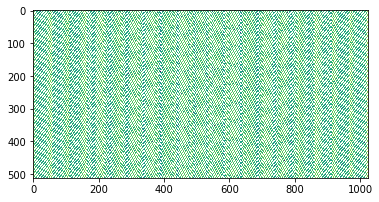

In [875]:
GR = torch.sum(torch.real(G),axis=0)
plt.imshow(GR,norm=LogNorm())

In [876]:
x_est = torch.fft.ifftn(X)

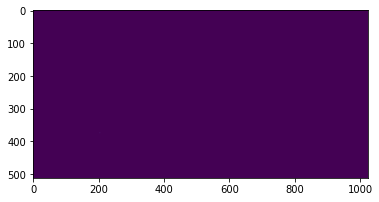

In [879]:
xR = torch.sum(torch.real(x_est),axis=0)
plt.imshow(xR)

In [96]:
# @dask.delayed
# def evt(ind,ct):
#     temp = pos
#     temp[ind[0],ind[1],ind[2]] += ct
#     return temp
# output = []
# for i in range(int(len(indx2)/100)):
#     ind = indx2[i]
#     ct = cts[i]
#     tmp = evt(ind,ct)
#     output.append(tmp)

# H = dask.delayed(sum)(output)

In [97]:
sum(cts)

3116

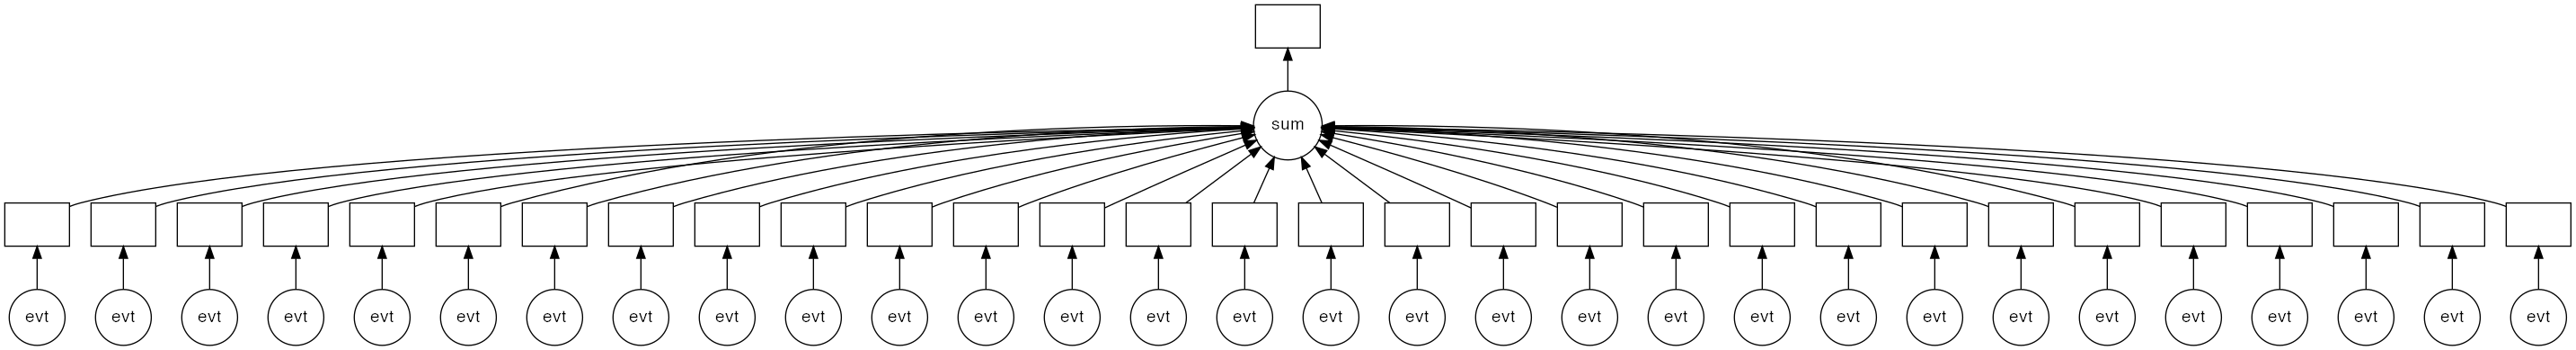

In [98]:
H.visualize()